In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer, euclidean_distance
import string
from sklearn.manifold import TSNE
import json

In [2]:
with open('../secrets.json') as file:
    secrets = json.load(file)
    connection_string = secrets['connection_string']
db = create_engine(connection_string)
df = pd.read_sql('SELECT * FROM NAP.article', con=db)

df

,id,post_id,post_title,url,score,publisher,headline,date_published,content
0,1,fra8wl,Top US general resists Trump administration?s ...,https://mondoweiss.net/2020/03/top-u-s-general...,10285,mondoweiss,Top U.S. general resists Trump administration?...,2020-03-28 15:44:00,A brave U.S. army lieutenant general may be ri...
1,2,frcvgj,Experts believe the explosion of coronavirus c...,https://www.si.com/soccer/2020/03/25/atalanta-...,2854,si,Atalanta vs Valencia linked to accelerating co...,2020-03-25 00:00:00,ROME (AP) ? It was the biggest soccer game in ...
2,3,fr5uqd,Boris Johnson's government is reportedly furio...,https://www.businessinsider.com/coronavirus-bo...,79397,businessinsider,Boris Johnson's government is reportedly furio...,2020-03-29 00:00:00,"UK government officials say there'll be ""recko..."
3,4,fr7uzc,Toyota Gearing Up To Build Ventilators And Fac...,https://www.carscoops.com/2020/03/toyota-geari...,4988,carscoops,Toyota Gearing Up To Build Ventilators And Fac...,2020-03-27 22:36:00,"The United States will soon have over 100,000 ..."
4,5,frbkqr,Prime Minister Justin Trudeau says Health Cana...,https://www.ctvnews.ca/health/coronavirus/trud...,2341,ctvnews,Trudeau vows 'no corners cut' in accepting mas...,2020-03-29 13:04:00,TORONTO -- Prime Minister Justin Trudeau says ...
...,...,...,...,...,...,...,...,...,...
5533,5550,m3c60o,"Us secretary of state calls Taiwan ""country""",https://www.taiwannews.com.tw/en/news/4148761,64413,taiwannews,US secretary of state calls Taiwan 'country',None,TAIPEI (Taiwan News) — U.S. Secretary of State...
5534,5551,m3o54g,Mysterious attacks on at least a dozen tankers...,https://www.businessinsider.com/israel-reporte...,1063,businessinsider,Mysterious attacks on at least a dozen tankers...,2021-03-12 00:00:00,Israel has targeted tankers carrying Iranian o...
5535,5552,m3igdb,Britain advises its citizens to flee Myanmar a...,https://www.theguardian.com/world/2021/mar/12/...,1651,theguardian,Britain advises its citizens to flee Myanmar a...,2021-03-12 00:00:00,The British government has urged its citizens ...
5536,5553,m3ibzy,"S. Korea to ban military exports to Myanmar, m...",http://yna.kr/AEN20210312009200325,1238,yna,"S. Korea to ban military exports to Myanmar, m...",2021-03-12 17:28:37,"As part of a humanitarian measure, the governm..."


In [3]:
df.iloc[-1, 3]

'https://www.theguardian.com/world/2021/mar/12/israel-bombed-a-dozen-ships-carrying-iranian-oil-or-weapons-report'

# Clustering content of articles

The first step is to use word2vec to get a numeric representation of the text data. This converts words into a vector. Based on the context of the words, similar words will have similar vectors.

Combine all the articles. I'm looking for overall patterns, so I want to see relationships across articles.

In [4]:
article_content = ''
for i in range(len(df)):
    article_content += df.iloc[i]['content'].lower()

In [5]:
# article = df.iloc[0]['content'].lower()

# tokenize into sentences then words
sent_tokens = sent_tokenize(article_content)
sents = [nltk.word_tokenize(s) for s in sent_tokens]

# remove stop words and tokens that are just punctuation
stop_words = set(stopwords.words('english')) 
for i, sent in enumerate(sents):
    new_sent = [word for word in sent if word not in stop_words and word not in string.punctuation]
    sents[i] = new_sent

# create a word vector - word must be used at least five times be a word vector
vec = Word2Vec(sents, min_count=5)

View the vocabulary

In [6]:
vec.wv.vocab

{'brave': <gensim.models.keyedvectors.Vocab at 0x7fb020f22e20>,
 'u.s.': <gensim.models.keyedvectors.Vocab at 0x7fb0209aef10>,
 'army': <gensim.models.keyedvectors.Vocab at 0x7fb0209aedc0>,
 'lieutenant': <gensim.models.keyedvectors.Vocab at 0x7fb0209aee50>,
 'general': <gensim.models.keyedvectors.Vocab at 0x7fb0209ae2e0>,
 'may': <gensim.models.keyedvectors.Vocab at 0x7fb0209ae1c0>,
 'risking': <gensim.models.keyedvectors.Vocab at 0x7fb0209ae250>,
 'career': <gensim.models.keyedvectors.Vocab at 0x7fb0209ae220>,
 'resist': <gensim.models.keyedvectors.Vocab at 0x7fb0209ae160>,
 'trump': <gensim.models.keyedvectors.Vocab at 0x7fb0209aeeb0>,
 'administration': <gensim.models.keyedvectors.Vocab at 0x7fb0209ae2b0>,
 'efforts': <gensim.models.keyedvectors.Vocab at 0x7fb0209ae430>,
 'provoke': <gensim.models.keyedvectors.Vocab at 0x7fb0209aed00>,
 'war': <gensim.models.keyedvectors.Vocab at 0x7fb0209ae310>,
 'iran': <gensim.models.keyedvectors.Vocab at 0x7fb0209ae400>,
 'robert': <gensim.mode

Just looking through the vocabulary from above, I looked up some words to see what other words were seen as similar.

In [7]:
vec.wv.most_similar('world')

[('globe', 0.6847552061080933),
 ('revolved', 0.6604900360107422),
 ('global', 0.5940524339675903),
 ('europe', 0.5667362213134766),
 ('world.', 0.5565930604934692),
 ('continent', 0.49897968769073486),
 ('circumambulating', 0.4969261586666107),
 ('2028', 0.4952055513858795),
 ('country', 0.48917606472969055),
 ('g20', 0.480573832988739)]

In [8]:
vec.wv.most_similar('virus')

[('covid-19', 0.8557495474815369),
 ('coronavirus', 0.8194559812545776),
 ('covid', 0.7850923538208008),
 ('disease', 0.7329883575439453),
 ('ebola', 0.7281095385551453),
 ('flu', 0.7094771862030029),
 ('asymptomatic', 0.7002915143966675),
 ('infection', 0.6881319284439087),
 ('severe', 0.6831991672515869),
 ('strain', 0.6741061210632324)]

In [9]:
vec.wv.most_similar('technology')

[('technologies', 0.9185742139816284),
 ('software', 0.841096043586731),
 ('communication', 0.8286746144294739),
 ('imagination', 0.8254599571228027),
 ('computer', 0.818476676940918),
 ('materials', 0.8154737949371338),
 ('artificial', 0.8142145872116089),
 ('insights', 0.806930661201477),
 ('digital', 0.8029811382293701),
 ('sensitive', 0.7805633544921875)]

In [10]:
vec.wv.most_similar('tracking')

[('database', 0.8515638709068298),
 ('collection', 0.835546612739563),
 ('raw', 0.8245724439620972),
 ('computer', 0.818579912185669),
 ('containing', 0.7974331378936768),
 ('genetic', 0.795477032661438),
 ('quantum', 0.7953643202781677),
 ('proprietary', 0.7951622009277344),
 ('genome', 0.7897100448608398),
 ('insights', 0.7882094979286194)]

Word vectors are 100-dimensional, so I have to use the TSNE class from scikit-learn to convert them to 2-dimensions for visualization.

In [11]:
vec.wv.__getitem__('world')

array([-1.0501168 , -1.2487289 ,  0.3168376 ,  0.129784  ,  1.5699309 ,
       -2.2730038 , -0.67878777,  1.3582451 , -2.3542898 ,  2.0728903 ,
       -0.23013687,  0.62274957,  0.5331967 ,  0.27871028, -2.186694  ,
       -1.5858752 ,  0.31143785, -2.8715875 ,  0.99477845,  0.59197086,
       -2.196998  ,  1.3762896 ,  0.73424125, -4.066756  , -1.6882285 ,
       -1.210198  ,  1.4299566 , -0.93926764,  0.0284129 , -0.67241263,
       -2.1749685 ,  0.6269164 , -0.4926752 ,  1.36573   , -0.25733   ,
        2.962279  ,  0.02496728,  4.2105374 ,  2.8851511 , -1.4411967 ,
       -0.30162334,  1.1120045 ,  1.1113577 , -2.0682247 , -0.11098308,
       -0.31616685,  0.18045953,  2.0668237 ,  3.8666205 , -0.5281206 ,
       -0.10595125, -2.1494448 , -1.0495805 , -1.3104272 ,  2.1097953 ,
        2.3162389 , -4.808245  ,  1.8131702 , -1.2540332 , -2.5894902 ,
        2.2874157 ,  0.6876048 , -3.2646475 ,  0.6561191 , -1.3539252 ,
        0.6364452 , -0.5740027 , -1.3417807 , -2.3295343 , -0.92

In [12]:
vectors = [vec.wv.__getitem__(word) for word in vec.wv.vocab]

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=17)
coords = tsne_model.fit_transform(vectors)

In [13]:
coords

array([[ 58.85926 ,  10.69044 ],
       [ 51.2583  ,  70.634895],
       [ 47.40563 ,  65.7419  ],
       ...,
       [-17.336624, -12.879463],
       [-48.343407, -59.717392],
       [-40.813637, -80.45394 ]], dtype=float32)

In [14]:
xs = []
ys = []

for coord in coords:
    xs.append(coord[0])
    ys.append(coord[1])

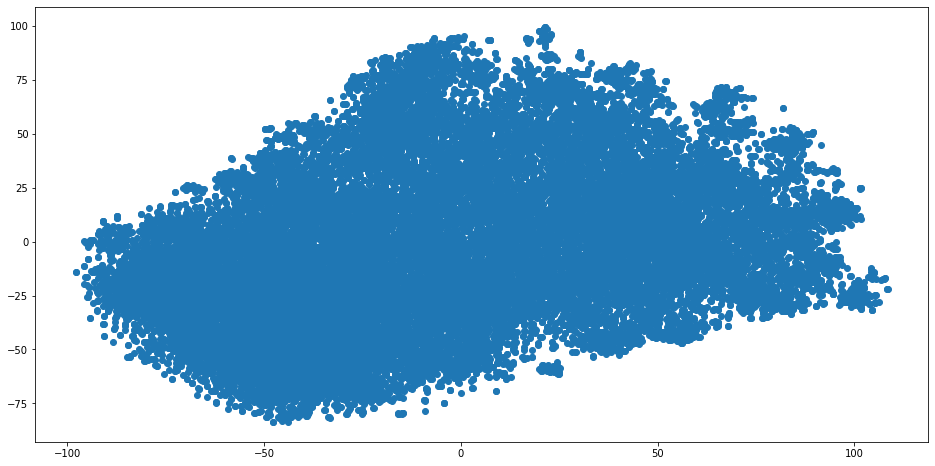

In [15]:
plt.figure(figsize=(16,8))
plt.scatter(xs, ys)
plt.show()

In [16]:
num_clusters = 5

clusterer = KMeansClusterer(num_clusters, euclidean_distance)
clusters = clusterer.cluster(coords, True, trace=True)

k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration


In [17]:
clusters

[2,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 4,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 4,
 2,
 2,
 4,
 2,
 4,
 2,
 2,
 4,
 4,
 2,
 2,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 2,
 3,
 4,
 2,
 2,
 2,
 4,
 4,
 4,
 2,
 2,
 2,
 3,
 2,
 0,
 4,
 2,
 2,
 4,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 4,
 4,
 2,
 4,
 4,
 2,
 2,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 4,
 3,
 2,
 2,
 4,
 4,
 2,
 4,
 2,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 4,
 3,
 0,
 3,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 4,
 4,
 4,
 4,
 0,
 2,
 2,
 2,
 2,
 2,
 4,
 3,
 2,
 2,
 2,
 4,
 2,
 4,
 4,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 2,
 3,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 4,
 4,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 4,
 2,
 2,
 4,
 4,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 3,
 2,
 2,
 4,
 1,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 2,


In [18]:
for i in range(len(coords)):
    print(f'{coords[i]} -- {clusters[i]}')

[58.85926 10.69044] -- 2
[51.2583   70.634895] -- 4
[47.40563 65.7419 ] -- 4
[-23.598347  51.54611 ] -- 4
[-19.272816  78.63083 ] -- 4
[22.36285  94.211784] -- 4
[43.12637    5.0505185] -- 2
[47.871017   0.3960948] -- 2
[27.378786 59.011192] -- 4
[-11.045409  90.65385 ] -- 4
[-10.257873  90.69866 ] -- 4
[72.03591  29.862488] -- 2
[38.050686 24.209412] -- 2
[48.28037  68.421745] -- 4
[48.73631 70.11079] -- 4
[-18.156738  78.199425] -- 4
[-21.680708  51.123238] -- 4
[-1.9417164 86.45186  ] -- 4
[-55.768898   -5.8317237] -- 1
[47.131496 67.872696] -- 4
[47.66083 65.79778] -- 4
[47.39283 68.77106] -- 4
[107.827576 -16.997175] -- 2
[108.40128  -21.995005] -- 2
[ 0.94289964 85.05225   ] -- 4
[80.31063  24.728127] -- 2
[27.402533 79.70461 ] -- 4
[ 96.98243 -23.16363] -- 2
[51.600666 39.450634] -- 2
[38.340958 29.065144] -- 4
[ 1.2723429 76.69207  ] -- 4
[57.056164 38.575817] -- 2
[74.66266  31.587776] -- 2
[-20.064835  81.74827 ] -- 4
[ 0.8371349 88.31013  ] -- 4
[-17.295334  81.80237 ] -- 4


[87.29842  12.693592] -- 2
[ 91.43257  -22.014523] -- 2
[22.258493 47.481113] -- 4
[95.21817  13.937458] -- 2
[-57.54952  -31.334898] -- 0
[98.815    17.595472] -- 2
[ 0.80048835 84.962944  ] -- 4
[-62.72358    -3.5197308] -- 1
[21.349535 91.60442 ] -- 4
[-64.89243   -7.713129] -- 1
[-11.820135   -3.8120697] -- 3
[63.81343 64.51225] -- 4
[-54.75477 -52.9538 ] -- 0
[58.105495  8.258795] -- 2
[ 71.65036  -13.079518] -- 2
[ 37.69791  -28.543737] -- 3
[61.806503 61.080803] -- 4
[60.27215  45.745888] -- 2
[81.31249    3.1328027] -- 2
[ 7.634848 82.16866 ] -- 4
[69.73245 68.08718] -- 4
[83.84135   -3.0750132] -- 2
[64.58251 63.1667 ] -- 4
[69.631165 68.05712 ] -- 4
[82.08621  15.012634] -- 2
[62.790134 62.468098] -- 4
[89.30933  17.728762] -- 2
[89.11353  17.821306] -- 2
[99.38435  11.401893] -- 2
[68.12276  40.946114] -- 2
[101.75207  -27.534746] -- 2
[69.47934  16.406277] -- 2
[-4.7849755 48.71161  ] -- 4
[69.2249 67.784 ] -- 4
[21.106709 98.69181 ] -- 4
[-0.7858489 94.793015 ] -- 4
[68.01

[42.11027  55.222748] -- 4
[31.485573 58.96008 ] -- 4
[ 84.58905  -28.794506] -- 2
[69.081055 55.64967 ] -- 2
[98.28411 14.8568 ] -- 2
[82.56236  19.405762] -- 2
[ 4.476376 88.36875 ] -- 4
[50.006916   5.6618714] -- 2
[79.80203  27.838049] -- 2
[49.083557 36.633022] -- 2
[48.09498 78.8655 ] -- 4
[80.58688 28.17863] -- 2
[ 73.63206  -21.758728] -- 2
[ 27.277782 -35.207695] -- 3
[  2.6246111 -59.297684 ] -- 3
[ 97.65631  -25.920319] -- 2
[4.601732  2.9369266] -- 3
[48.820034 68.57496 ] -- 4
[-50.14207  -68.188416] -- 0
[ 7.3388724 25.89716  ] -- 4
[90.41626 11.20802] -- 2
[47.341564 23.254536] -- 2
[ 88.16445  -17.483719] -- 2
[63.132668 19.796646] -- 2
[73.997986 57.154263] -- 2
[ 51.316494 -27.434795] -- 2
[53.811142 62.985012] -- 4
[21.09279  98.751686] -- 4
[ 99.48785  -26.219439] -- 2
[ 46.198357 -25.22266 ] -- 3
[ 82.53825  -32.291725] -- 2
[ 74.289566 -11.796049] -- 2
[ 79.00356  -32.181377] -- 2
[-30.535078 -57.61906 ] -- 0
[24.921255 32.39892 ] -- 4
[25.41973  -8.471504] -- 3
[3

[24.279125 12.602299] -- 3
[-58.99621 -70.306  ] -- 0
[81.38814  -8.569398] -- 2
[62.964905 36.19831 ] -- 2
[13.783971 84.452354] -- 4
[13.795407 84.43935 ] -- 4
[89.474594 50.8778  ] -- 2
[-36.31479  39.75259] -- 1
[70.59873    2.4159472] -- 2
[-52.96043   29.939732] -- 1
[-75.71867    2.861091] -- 1
[-31.281193  48.92208 ] -- 1
[49.237923 -7.557964] -- 2
[70.79517 47.87975] -- 2
[29.169586 78.68523 ] -- 4
[-85.28823  -39.036823] -- 0
[19.985321 97.88436 ] -- 4
[104.26101  -13.985214] -- 2
[36.93065   9.617336] -- 2
[-26.065079 -61.409843] -- 0
[103.06401  -24.952618] -- 2
[-37.058586 -11.978804] -- 1
[ 37.559914 -45.344574] -- 3
[35.293064 -7.478864] -- 3
[69.33731    2.9640794] -- 2
[-18.531336  62.13439 ] -- 4
[-69.88188   13.093678] -- 1
[ 10.583652 -53.54961 ] -- 3
[ 65.27826  -37.615467] -- 2
[32.51042    8.5426655] -- 2
[-56.879906 -71.03923 ] -- 0
[-14.1617565  52.836567 ] -- 4
[-48.608223  35.652622] -- 1
[42.9222  82.50325] -- 4
[11.617796 49.867863] -- 4
[ 98.22177  -24.290

[60.85696 12.52484] -- 2
[25.978119 61.89155 ] -- 4
[15.267401 40.170956] -- 4
[19.381462 56.089993] -- 4
[29.25272 70.30594] -- 4
[63.594368  -3.8956802] -- 2
[ 1.3900497e-02 -3.1613815e+01] -- 3
[18.825346 74.748055] -- 4
[-85.39267 -32.79094] -- 0
[39.830326 29.873741] -- 2
[99.70604  15.474572] -- 2
[51.218422   -0.23693778] -- 2
[ 15.035335 -13.32376 ] -- 3
[37.370552 14.761065] -- 2
[80.901825 32.68033 ] -- 2
[ 9.791723 23.882362] -- 4
[ 76.84861  -35.002876] -- 2
[ 46.519684 -25.185347] -- 3
[ 72.978905 -29.39199 ] -- 2
[ 75.292076 -29.041302] -- 2
[ 39.040085 -46.554077] -- 3
[-46.066963    4.4298143] -- 1
[ 6.445183 70.549095] -- 4
[-2.3546271  2.6914725] -- 3
[-1.5582707  4.4019346] -- 3
[-21.495466  61.82843 ] -- 4
[84.85121 41.46745] -- 2
[82.30744  43.585564] -- 2
[82.2883   24.888012] -- 2
[27.711853  6.76136 ] -- 3
[91.20794  -9.660575] -- 2
[12.615919 27.915628] -- 4
[-29.053732   -7.4233117] -- 1
[82.22394  30.774456] -- 2
[-51.8051    -9.598323] -- 1
[87.875916 35.779

[ 31.297564 -38.421986] -- 3
[87.37157   -3.4050143] -- 2
[ 66.322136 -11.466514] -- 2
[ 42.17956  -44.502163] -- 3
[ 39.659092 -33.466263] -- 3
[85.405754 12.367947] -- 2
[82.97705 32.07493] -- 2
[ 15.939924 -24.557882] -- 3
[-10.996741 -36.521065] -- 3
[ 79.95068  -12.279709] -- 2
[89.16887    0.1350969] -- 2
[55.98033    3.9387448] -- 2
[13.513687 42.11197 ] -- 4
[ 43.418797 -47.6956  ] -- 3
[45.809383  -3.1560202] -- 2
[ 60.0421  -38.57456] -- 2
[ 3.8580053 65.31915  ] -- 4
[34.418137 67.954704] -- 4
[  3.1039019 -24.69368  ] -- 3
[-19.693546   6.704977] -- 1
[96.12304  16.392054] -- 2
[68.48145   -2.6698093] -- 2
[ 59.111942 -23.949612] -- 2
[78.13527  26.620665] -- 2
[21.268684 94.588486] -- 4
[50.635128 16.883478] -- 2
[-10.843586  76.463936] -- 4
[45.222874 12.468023] -- 2
[  2.8237197 -19.717104 ] -- 3
[  8.850081 -60.36698 ] -- 3
[-28.578348 -56.39343 ] -- 0
[ 46.83428  -15.791727] -- 2
[ 1.2929147 69.2592   ] -- 4
[61.98205  -9.226408] -- 2
[90.14955  -8.289935] -- 2
[ 55.98

[-79.96967  -32.719368] -- 0
[43.01728  18.376987] -- 2
[-29.523317  -8.223383] -- 1
[-67.38145  -19.082756] -- 0
[-43.417988 -26.345118] -- 0
[-13.741756  69.536514] -- 4
[-75.038284     0.73249465] -- 1
[-39.78993  -48.738735] -- 0
[-37.355324 -63.602436] -- 0
[-41.685925  16.285194] -- 1
[14.947894 28.094007] -- 4
[-48.784702 -60.833267] -- 0
[ 44.1243   -43.670338] -- 3
[25.56455 72.89925] -- 4
[30.762224 61.230587] -- 4
[-83.36181 -32.03853] -- 0
[ -7.41139  -15.479791] -- 3
[-24.70582   62.397205] -- 4
[-22.974358 -26.167253] -- 0
[67.326385   4.8903356] -- 2
[  4.934528 -12.771413] -- 3
[-86.61016  -16.390533] -- 0
[  8.3161335 -15.651486 ] -- 3
[26.090305 71.614365] -- 4
[-35.20488   52.692196] -- 1
[ 8.864656 68.29492 ] -- 4
[ -1.5180908 -30.117508 ] -- 3
[79.09285   -2.4619899] -- 2
[81.007195 28.576275] -- 2
[ 45.95937  -46.130585] -- 3
[-75.545815 -18.517141] -- 0
[-44.009563  52.016773] -- 1
[23.44259  -8.474152] -- 3
[35.78836 31.48809] -- 4
[-59.890873 -36.07093 ] -- 0
[

[-24.684729 -28.900484] -- 0
[-10.801845  11.777963] -- 1
[-42.695038  -7.126905] -- 1
[28.265383 32.72995 ] -- 4
[22.869568 69.004974] -- 4
[54.31831  14.855718] -- 2
[ 3.0725534 55.08713  ] -- 4
[53.104828 44.075394] -- 2
[-62.110027 -42.889736] -- 0
[36.083385 66.15883 ] -- 4
[-54.82223    -3.9084227] -- 1
[18.133251 33.86986 ] -- 4
[35.03297 27.59724] -- 4
[  3.9939682 -23.701935 ] -- 3
[-46.867348  15.81881 ] -- 1
[-38.023098 -48.57293 ] -- 0
[-45.27829  -27.893673] -- 0
[-81.00192  -52.835857] -- 0
[25.447208 18.129156] -- 4
[ 8.9832325 69.93154  ] -- 4
[-15.852182 -38.19793 ] -- 3
[47.894802    0.18763761] -- 2
[-69.94896  -28.086082] -- 0
[-63.43197      0.84612364] -- 1
[20.014576 11.365258] -- 3
[-53.38116   -6.464954] -- 1
[20.885286 94.26762 ] -- 4
[ 8.640691 65.508934] -- 4
[ 3.5796795 65.90092  ] -- 4
[-59.727455  12.84553 ] -- 1
[-42.636326    7.1057377] -- 1
[-0.71312225 21.695812  ] -- 4
[-23.668203  58.323723] -- 4
[-21.43192  52.28628] -- 4
[15.341152 24.942327] -- 4

[-36.14343   43.678284] -- 1
[36.29787  25.319586] -- 2
[-45.176533    2.8589568] -- 1
[-9.522119 10.717406] -- 1
[24.198416 39.658207] -- 4
[88.349014 46.053566] -- 2
[-29.487556   9.288215] -- 1
[-3.5002365 -4.080068 ] -- 3
[-2.83623   -6.3506136] -- 3
[11.800441 29.881945] -- 4
[ 23.309065 -14.899463] -- 3
[ 18.67923  -15.996597] -- 3
[-15.832217  -3.94301 ] -- 1
[94.47695  18.491142] -- 2
[12.831154 54.56441 ] -- 4
[96.1942   16.620996] -- 2
[59.762398  8.624953] -- 2
[-15.114598 -27.964544] -- 3
[-90.74768  -43.676235] -- 0
[16.272013  -7.2744503] -- 3
[ 2.7114613 63.926838 ] -- 4
[14.024001 68.38496 ] -- 4
[20.374054 86.63023 ] -- 4
[47.05855 29.12942] -- 2
[43.32116 68.25576] -- 4
[13.322397 70.91965 ] -- 4
[13.510167 71.708   ] -- 4
[36.690647 15.766693] -- 2
[34.990654 43.042107] -- 4
[16.069796 66.0144  ] -- 4
[-13.950588  84.80965 ] -- 4
[-32.60195     6.8750086] -- 1
[ 8.842686 65.13592 ] -- 4
[  6.9896407 -31.938261 ] -- 3
[ -8.577659 -24.12718 ] -- 3
[17.53092  22.556828]

[29.346605 37.835316] -- 4
[-21.209223 -40.919285] -- 0
[-15.488013   -3.5246968] -- 1
[-22.189016 -17.58441 ] -- 3
[  3.0564828 -32.45238  ] -- 3
[-11.426575  70.677505] -- 4
[-57.727337 -56.91262 ] -- 0
[ 6.762896 10.386727] -- 3
[-44.59813 -28.53547] -- 0
[-12.423958    0.4990929] -- 1
[-19.835829 -45.033867] -- 0
[-27.57288  -55.396687] -- 0
[-34.090282  28.298273] -- 1
[39.22643  72.960655] -- 4
[-11.268466 -15.164142] -- 3
[ 36.98624  -37.780586] -- 3
[11.560288 14.600046] -- 3
[ -8.62398  -55.479465] -- 3
[38.06032   -4.5481377] -- 2
[60.753323 32.44124 ] -- 2
[46.398663 34.33707 ] -- 2
[-61.58769 -45.52562] -- 0
[-33.078766 -10.289699] -- 1
[ 1.8676668 60.029808 ] -- 4
[35.265232 68.49139 ] -- 4
[-89.77343     2.5720081] -- 1
[-88.430725   -1.7251351] -- 1
[ -6.4551673 -45.020752 ] -- 3
[49.574993 49.747368] -- 4
[48.41022    7.7613716] -- 2
[-42.54822   18.171164] -- 1
[-26.668562  -9.719309] -- 1
[-8.5365776e+01 -6.0942914e-02] -- 1
[-21.782145 -32.26914 ] -- 0
[-32.041874 -1

[21.320293   3.8224497] -- 3
[-56.27045   -7.296003] -- 1
[40.6306   24.511192] -- 2
[ 31.908607 -37.86327 ] -- 3
[-40.13028 -21.11892] -- 0
[70.08678  21.720766] -- 2
[51.935493 46.9743  ] -- 4
[-29.131945  49.233875] -- 1
[32.12214  21.661947] -- 2
[26.180122 13.437459] -- 3
[16.703691 19.44604 ] -- 4
[-10.567657  52.801746] -- 4
[23.52224  14.734106] -- 3
[34.543995 54.602264] -- 4
[30.826283  7.09659 ] -- 2
[  3.8561902 -51.64849  ] -- 3
[ -8.889799 -28.537825] -- 3
[-56.61176  -17.987955] -- 0
[-39.976223  40.58359 ] -- 1
[-4.0971565  9.223626 ] -- 3
[-66.45334 -57.6033 ] -- 0
[ -4.973787 -37.217926] -- 3
[-14.810698  78.306755] -- 4
[68.229195 -8.550774] -- 2
[-26.911116 -37.632664] -- 0
[-36.200554  -8.185988] -- 1
[-58.61787   -8.131098] -- 1
[-31.124487 -50.23597 ] -- 0
[  2.4635947 -17.36156  ] -- 3
[-50.514206  25.040289] -- 1
[-18.450209  57.67069 ] -- 4
[22.540457 74.80853 ] -- 4
[-77.7456    -5.360531] -- 1
[-54.98025 -56.76785] -- 0
[-65.588936 -58.38691 ] -- 0
[16.13846

[-19.498037 -20.33091 ] -- 3
[48.545685  -6.9068565] -- 2
[13.395442 24.807318] -- 4
[ 60.737305  -14.1654415] -- 2
[ 18.31247  -34.672283] -- 3
[-48.533695 -66.64985 ] -- 0
[-29.523937 -62.59153 ] -- 0
[-35.81846 -68.2851 ] -- 0
[-52.521008   -7.7269897] -- 1
[-43.364086  16.441502] -- 1
[ 34.035164 -18.109413] -- 3
[ 52.141026 -21.689898] -- 2
[-10.881916 -46.236156] -- 3
[ 12.28777 -38.70408] -- 3
[ 57.721085 -11.136816] -- 2
[ 16.024137 -38.584698] -- 3
[-38.357666 -64.15575 ] -- 0
[-38.96404 -34.80428] -- 0
[-70.141075  11.744339] -- 1
[-17.719057 -55.145065] -- 0
[-15.496419    2.1573012] -- 1
[ 51.864807 -20.178965] -- 2
[ 43.813553 -44.370674] -- 3
[17.715435 44.19018 ] -- 4
[ 62.42853  -10.496383] -- 2
[ 36.562786 -21.835598] -- 3
[-32.03539  -16.107132] -- 1
[ 58.435844 -41.798363] -- 2
[-40.918762 -13.824498] -- 1
[ 74.92759  -15.424139] -- 2
[-41.019753 -66.4965  ] -- 0
[72.01886 -8.11355] -- 2
[ 74.6637   -15.174716] -- 2
[ 22.654423 -37.36458 ] -- 3
[-65.147156 -46.096867

[-28.491865   1.915894] -- 1
[ 49.49462  -33.454525] -- 3
[34.381306  -5.5856595] -- 3
[-26.728346 -67.92912 ] -- 0
[ -0.14389807 -11.937546  ] -- 3
[-49.668945 -35.2251  ] -- 0
[68.510376 24.923565] -- 2
[-49.03428  -38.911198] -- 0
[ 10.422298 -31.709656] -- 3
[ 11.511832 -28.382685] -- 3
[  6.3725705 -40.422337 ] -- 3
[20.476412 52.72877 ] -- 4
[-9.799545 87.89024 ] -- 4
[-9.650239 87.298965] -- 4
[ -8.241906 -19.971556] -- 3
[ -2.7966895 -58.236195 ] -- 3
[-87.99096  -27.752174] -- 0
[-43.36162 -71.06809] -- 0
[-39.499386 -51.177746] -- 0
[-34.589584 -49.77637 ] -- 0
[ 21.631624 -15.269325] -- 3
[13.10581  47.042664] -- 4
[44.524387  -3.4614375] -- 2
[71.548416 -4.733635] -- 2
[-47.360733 -68.943535] -- 0
[-44.784096 -66.47601 ] -- 0
[  1.355795 -12.943182] -- 3
[ 23.762293 -33.407345] -- 3
[-16.091587  63.036415] -- 4
[-66.40826  -12.282098] -- 0
[-83.66291    -9.5094595] -- 0
[-69.06691  -12.047324] -- 0
[-43.333527 -24.240698] -- 0
[-31.028152   4.034028] -- 1
[-5.0054374 19.341

[-66.51541  -26.890787] -- 0
[-16.670586 -14.536001] -- 3
[ 3.790793 39.34601 ] -- 4
[-19.900177 -55.87351 ] -- 0
[6.4888434 3.7397814] -- 3
[-19.34222 -46.31341] -- 0
[-24.856764 -71.54354 ] -- 0
[-14.684288  72.36487 ] -- 4
[-62.34544   17.773954] -- 1
[ 11.347459 -33.159092] -- 3
[-12.332976     0.49612555] -- 1
[ 2.7838864 22.95706  ] -- 4
[-34.29808     3.4287355] -- 1
[13.889686   1.8764572] -- 3
[-78.10108 -54.58224] -- 0
[-3.4537706  5.5685472] -- 3
[-4.9914246 32.501167 ] -- 4
[-44.904556  11.421003] -- 1
[-28.797518 -72.19571 ] -- 0
[-17.161285 -44.01216 ] -- 0
[ -9.239286 -78.76641 ] -- 0
[44.500362 17.525335] -- 2
[ 6.553236 16.44979 ] -- 4
[ 31.828297 -38.06787 ] -- 3
[-31.823675 -37.12772 ] -- 0
[26.64898    7.6589375] -- 3
[-39.836067 -57.245247] -- 0
[-28.87652  -53.042873] -- 0
[-33.65907  39.37662] -- 1
[-12.535344   6.759102] -- 1
[  7.0979595 -57.00334  ] -- 3
[-39.453373 -49.717293] -- 0
[-30.406607    5.0627704] -- 1
[26.896128  3.851628] -- 3
[ 68.36295  -17.3166

[-4.37538 72.88717] -- 4
[-22.74761  -43.573803] -- 0
[-20.937971 -11.177757] -- 1
[-13.590898  12.644467] -- 1
[-20.59348  -58.929863] -- 0
[ -3.1166923 -59.029106 ] -- 3
[-77.70783  -24.090408] -- 0
[-68.284676 -27.595545] -- 0
[ 4.9011297 36.85998  ] -- 4
[ 4.077949 32.765133] -- 4
[-83.52397  -43.779568] -- 0
[-49.21117    -1.5509294] -- 1
[  2.6605506 -22.931955 ] -- 3
[-35.69823  20.53308] -- 1
[ 31.505243 -24.794775] -- 3
[-62.57701  -27.925713] -- 0
[-34.804344 -27.995625] -- 0
[ -9.768769 -65.26869 ] -- 3
[-33.091263 -40.650414] -- 0
[ 42.64711  -48.707462] -- 3
[ 3.0240731 30.476662 ] -- 4
[18.589476 71.3921  ] -- 4
[-50.28032  -28.561007] -- 0
[-87.15588  -25.655691] -- 0
[-64.94163 -32.46954] -- 0
[-14.461658 -42.1018  ] -- 3
[33.90898   10.2157755] -- 2
[-72.558136  -2.207116] -- 1
[65.17686  12.755986] -- 2
[-23.695822  39.91544 ] -- 1
[-11.70459  -26.957006] -- 3
[31.586615 26.359453] -- 4
[-41.170498 -25.463165] -- 0
[-43.685543 -18.19672 ] -- 0
[ 32.677917 -14.6016  ] 

[-21.731133 -72.79782 ] -- 0
[-15.93788   28.518585] -- 1
[-54.797997 -14.965522] -- 0
[-49.917767  36.794792] -- 1
[ -4.180181 -74.922485] -- 3
[-17.029043   -2.7016227] -- 1
[-21.154188  34.9609  ] -- 1
[-5.266732 -9.038588] -- 3
[-21.151703 -28.680923] -- 3
[-13.477409     0.21237178] -- 1
[-24.379364 -58.365585] -- 0
[-13.342714 -52.983982] -- 3
[-23.289988 -69.48308 ] -- 0
[ 67.678505 -16.03869 ] -- 2
[-20.432253   -2.3139174] -- 1
[-26.150745 -17.693798] -- 1
[-22.815226 -47.81567 ] -- 0
[-40.277134 -69.268974] -- 0
[-19.570496 -65.82657 ] -- 0
[ 0.71907467 45.015957  ] -- 4
[-2.2573633e+01 -3.9016104e-03] -- 1
[ -8.671338 -17.716139] -- 3
[-2.0165274 16.126642 ] -- 1
[-51.416496 -43.079624] -- 0
[-74.9184  -18.94012] -- 0
[48.659702 46.548687] -- 4
[29.507057 21.197462] -- 4
[-62.09832  11.95194] -- 1
[-68.44774  -37.226852] -- 0
[-63.53321 -69.16463] -- 0
[-8.73126  23.040766] -- 1
[-11.421072  58.589268] -- 4
[-23.036617 -16.14111 ] -- 1
[30.857546 19.247843] -- 2
[ 12.913131 

[ 39.848312 -14.065403] -- 3
[-44.759727 -22.607838] -- 0
[-36.58626  -71.214676] -- 0
[ -9.520457 -55.663628] -- 3
[-66.93698  -28.924442] -- 0
[-43.92946 -57.29618] -- 0
[-76.9762   -27.527151] -- 0
[ -0.5232837 -32.982273 ] -- 3
[-31.681513 -33.52702 ] -- 0
[-27.486197 -60.035828] -- 0
[-44.998573  13.567709] -- 1
[-49.261406    5.6186643] -- 1
[-53.245747 -66.927704] -- 0
[-71.8379   -47.573383] -- 0
[-49.342426 -48.689514] -- 0
[-49.726284 -33.01491 ] -- 0
[-23.881716  -9.961468] -- 1
[-59.607265 -43.782616] -- 0
[-32.9423  -7.1522] -- 1
[-41.491943 -56.66786 ] -- 0
[-11.243793 -28.714527] -- 3
[-69.25283 -52.7018 ] -- 0
[-44.178806 -39.77682 ] -- 0
[ 28.472664 -44.740826] -- 3
[-58.47046 -62.68195] -- 0
[-43.697807 -14.770562] -- 1
[-62.30063  -19.591866] -- 0
[-32.615063  24.890991] -- 1
[-32.326702 -53.88227 ] -- 0
[ 28.923887 -27.723646] -- 3
[  9.449389 -56.090828] -- 3
[-0.76288384 -8.0780735 ] -- 3
[22.959417 29.147722] -- 4
[-41.22862  -15.189351] -- 1
[-89.7304  -20.98324

[ 43.02449  -25.458786] -- 3
[ -9.591427 -54.52849 ] -- 3
[-40.49711  -59.226933] -- 0
[ 32.858093 -21.55589 ] -- 3
[ 39.73138  -50.713318] -- 3
[-8.947685e+01 -1.485735e-03] -- 1
[-21.53166 -69.60249] -- 0
[-35.778915  -9.815873] -- 1
[-24.657444 -67.66497 ] -- 0
[-27.945911 -60.083294] -- 0
[-27.6004   -60.111736] -- 0
[-78.91372  -27.034163] -- 0
[-61.91336  -31.186182] -- 0
[ 45.16559 -26.32829] -- 3
[-86.461914    -0.82996565] -- 1
[13.36234     0.47403148] -- 3
[-84.54015 -47.93244] -- 0
[ 0.6862339 -4.5752773] -- 3
[  4.977552 -18.89408 ] -- 3
[-29.905428 -20.893646] -- 0
[-66.74564 -16.6322 ] -- 0
[-28.426884 -58.62063 ] -- 0
[-78.75402 -28.85821] -- 0
[-29.835321 -72.50891 ] -- 0
[ 47.730846 -39.571705] -- 3
[-40.849075 -66.31401 ] -- 0
[-60.758762 -13.46935 ] -- 0
[-64.94087  -32.426247] -- 0
[-73.30487  -30.930038] -- 0
[-82.87041    -3.0654266] -- 1
[-60.17813 -33.3331 ] -- 0
[ 4.7894864 77.10445  ] -- 4
[-57.954586     0.64827365] -- 1
[-16.087244 -17.182064] -- 3
[-10.448

[-55.923584 -39.930332] -- 0
[-31.80231 -59.04117] -- 0
[-66.58289  -13.457241] -- 0
[-25.684654  33.538902] -- 1
[ 22.406094 -23.003288] -- 3
[ 19.608335 -23.673801] -- 3
[-39.433403  43.8545  ] -- 1
[-34.978012 -62.9171  ] -- 0
[7.870251   0.89285046] -- 3
[-22.10569  -47.871246] -- 0
[ 24.880072 -26.274446] -- 3
[-17.37893  42.24492] -- 4
[-97.82298  -14.270418] -- 0
[-45.774082   8.809334] -- 1
[-45.76083    8.810053] -- 1
[-71.13756  -19.349628] -- 0
[-79.142235 -26.351168] -- 0
[ 25.787575 -13.466214] -- 3
[ -7.912968 -57.467667] -- 3
[ 25.350706 -13.687109] -- 3
[-7.1649847 -2.6591747] -- 3
[ 27.843046 -16.555851] -- 3
[13.1513405 16.580355 ] -- 4
[13.081875 16.73822 ] -- 4
[12.430151 13.794136] -- 3
[12.218407 13.186875] -- 3
[-15.577314  35.29053 ] -- 4
[-68.48986  -28.961039] -- 0
[-55.68675 -78.50245] -- 0
[-5.7729664 11.071166 ] -- 1
[-24.470085  -8.241025] -- 1
[-26.317753   -3.2600913] -- 1
[-80.56416  -22.771297] -- 0
[ 3.6235068 -3.1288192] -- 3
[-52.60367  34.58049] --

Make a dictionary where each cluster is a key. This will make it easier to plot the clusters

In [19]:
clustered_coords = {}

for i in range(num_clusters):
    clustered_coords.update({i: [c for j, c in enumerate(coords) if clusters[j] == i]})
    
clustered_coords

{0: [array([-36.9757, -30.1192], dtype=float32),
  array([-44.003185, -49.454544], dtype=float32),
  array([-82.371796 , -13.9738245], dtype=float32),
  array([-53.989475, -19.38805 ], dtype=float32),
  array([-16.958128, -48.761997], dtype=float32),
  array([-48.438835, -40.35153 ], dtype=float32),
  array([-53.376186, -30.08469 ], dtype=float32),
  array([-39.93311 , -44.269897], dtype=float32),
  array([-58.0316  , -21.137905], dtype=float32),
  array([-36.484165, -47.732784], dtype=float32),
  array([-41.992336, -39.920353], dtype=float32),
  array([-37.396694, -17.457535], dtype=float32),
  array([-32.87831, -50.80016], dtype=float32),
  array([-50.489063, -34.20683 ], dtype=float32),
  array([-31.693254, -51.266518], dtype=float32),
  array([-27.848127, -43.28533 ], dtype=float32),
  array([-24.800373, -43.59541 ], dtype=float32),
  array([-35.87491, -49.38594], dtype=float32),
  array([-64.373   , -53.962368], dtype=float32),
  array([-24.80659, -48.9207 ], dtype=float32),
  arr

Plot the clusters

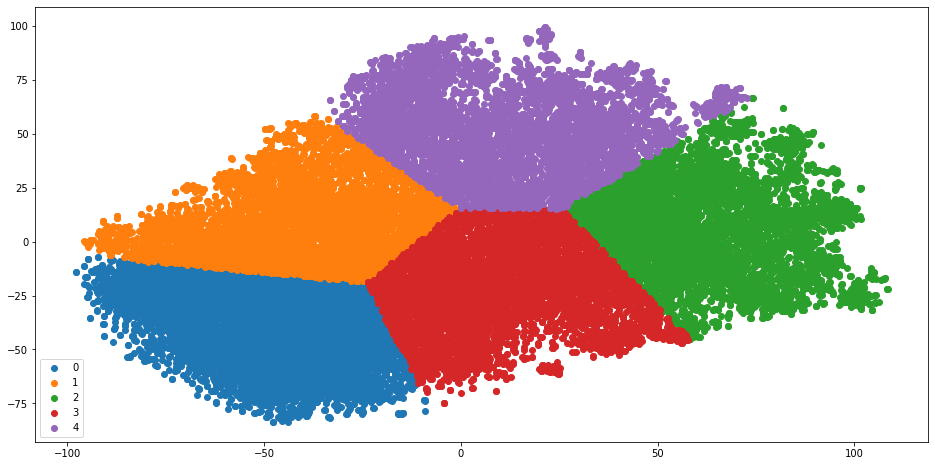

In [20]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(111)

for key in clustered_coords.keys():
    cluster = clustered_coords[key]
    
    xs = []
    ys = []
    
    for c in cluster:
        xs.append(c[0])
        ys.append(c[1])
        
    ax.scatter(xs, ys, label=str(key))

ax.legend(loc='lower left')
plt.show()

### Next, I look at what words show up in each cluster.
Since the clusters array should still be parallel to the vocabulary, I can just make a dictionary with those.

In [21]:
cluster_dict = {}

for i, word in enumerate(vec.wv.vocab):
    cluster_dict.update({word: (coords[i], clusters[i])})

cluster_dict

{'brave': (array([58.85926, 10.69044], dtype=float32), 2),
 'u.s.': (array([51.2583  , 70.634895], dtype=float32), 4),
 'army': (array([47.40563, 65.7419 ], dtype=float32), 4),
 'lieutenant': (array([-23.598347,  51.54611 ], dtype=float32), 4),
 'general': (array([-19.272816,  78.63083 ], dtype=float32), 4),
 'may': (array([22.36285 , 94.211784], dtype=float32), 4),
 'risking': (array([43.12637  ,  5.0505185], dtype=float32), 2),
 'career': (array([47.871017 ,  0.3960948], dtype=float32), 2),
 'resist': (array([27.378786, 59.011192], dtype=float32), 4),
 'trump': (array([-11.045409,  90.65385 ], dtype=float32), 4),
 'administration': (array([-10.257873,  90.69866 ], dtype=float32), 4),
 'efforts': (array([72.03591 , 29.862488], dtype=float32), 2),
 'provoke': (array([38.050686, 24.209412], dtype=float32), 2),
 'war': (array([48.28037 , 68.421745], dtype=float32), 4),
 'iran': (array([48.73631, 70.11079], dtype=float32), 4),
 'robert': (array([-18.156738,  78.199425], dtype=float32), 4)

In [22]:
clust0 = [key for key in cluster_dict.keys() if cluster_dict[key][1] == 0]
clust1 = [key for key in cluster_dict.keys() if cluster_dict[key][1] == 1]

In [23]:
for i in range(num_clusters):
    clust = [key for key in cluster_dict.keys() if cluster_dict[key][1] == i]
    print(f'Cluster {i}:')
    print(clust)
    print()

Cluster 0:
['instigate', 'neutralize', 'warmongering', 'jeopardizing', 'escalates', 'pathetic', 'hugging', 'hypotheses', 'ol', 'restarting', 'leagues', 'squads', 'unforeseen', 'toyota', 'mercedes', 'full-face', 'goggles', 'collaboratively', 'comb', 'frames', '209', 'exponential', 'breadth', 'subsided', 'selfies', 'dice', 'exacerbates', 'billion-dollar', 'importer', 'sigh', 'pie', 'clicked', 'largest-ever', 'ei', 'four-week', 'pop-up', 'essence', 'contemplating', 'saskatoon', 'cheques', 'wimbledon', 'payout', 'fortunate', 'thrust', 'digest', 'hoarding', 'exemplary', 'needy', 'cataclysmic', 'intel', 'posture', '110,000', 'dispatch', "'at", "'but", 'braces', "'well", 'qom', 'descending', 'curbside', 'narrowed', '4/29', '13/29', 'curzon', 'sanitisers', 'rcn', 'donna', 'say.', 'need.', 'fielding', 'petrified', 'beholden', 'care.', 'bongelaar', 'antennas', 'commence', 'indignation', 'slows', 'third-highest', 'impromptu', 'devise', 'competitor', '52,000', 'millimetres', 'bundle', 'bundles', '